# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определять рыночную стоимость объектов недвижимости. Плюс задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Открываем файл, изучаем информацию

#### Описание данных
- ***airports_nearest*** — расстояние до ближайшего аэропорта в метрах (м)
- ***balcony*** — число балконов
- ***ceiling_height*** — высота потолков (м)
- ***cityCenters_nearest*** — расстояние до центра города (м)
- ***days_exposition*** — сколько дней было размещено объявление (от публикации до снятия)
- ***first_day_exposition*** — дата публикации
- ***floor*** — этаж
- ***floors_total*** — всего этажей в доме
- ***is_apartment*** — апартаменты (булев тип)
- ***kitchen_area*** — площадь кухни в квадратных метрах (м²)
- ***last_price*** — цена на момент снятия с публикации
- ***living_area*** — жилая площадь в квадратных метрах(м²)
- ***locality_name*** — название населённого пункта
- ***open_plan*** — свободная планировка (булев тип)
- ***parks_around3000*** — число парков в радиусе 3 км
- ***parks_nearest*** — расстояние до ближайшего парка (м)
- ***ponds_around3000*** — число водоёмов в радиусе 3 км
- ***ponds_nearest*** — расстояние до ближайшего водоёма (м)
- ***rooms*** — число комнат
- ***studio*** — квартира-студия (булев тип)
- ***total_area*** — площадь квартиры в квадратных метрах (м²)
- ***total_images*** — число фотографий квартиры в объявлении

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

from pymystem3 import Mystem # Импорт лемм
m = Mystem()
from collections import Counter # Для расчета кол-ва лемм

#### Вывод первых строк, info, describe, Корректность написания столбцов

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
data.describe().T
# days_exposition, ponds_nearest - Видимо много выбросов. Большое отличие Среднего от Медианы

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [5]:
data.columns # Проверка отсутствия пропусков в названии столбцов + просмотр названия столбцов

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Вывод

- [x]  <span style="color:green">***total_images*** Поле формата int, Пропусков в данных нет, максимальное значение 50 фото, изменений в столбце не требуется
- [ ]  <span style="color:red">***last_price*** - Поле заполненно полностью, странное минимальное значение = 12 190, квартир с такой ценой явно не бывает. Нужно почистить от Всплесков, экстримальные цены нам не к чему.
- [ ]  <span style="color:red"> ***total_area*** - Среднее значение сильно отличается от Медианы. Нужно убирать Всплески - Квартиры по 900 м
- [ ]  <span style="color:red"> ***first_day_exposition*** - Необходимо перевести в формат даты, пропусков в поле нет
- [x]  <span style="color:green">***rooms*** - Формат int, Пропусков в данных нет - коррекций в поле не требуется
- [ ]  <span style="color:red"> ***ceiling_height*** - Есть 3 значения с высотой потолков менее 2х метров, поле заполнено не полностью, есть потолки сто метров. Поле не является обязательным, но можно его разделить на группы: от 2,5м; от 2,7м; от 3м; от 4м. Итого подрезать Артефакты и добавить группировку, где есть это значение
- [ ]  <span style="color:red"> ***floors_total*** Перевести поле в int, есть пустые значения 
- [ ]  <span style="color:red"> ***living_area*** - Есть пустые значения и артефакты, заполнить по Коэффициенту и в зависимости от Общей площади и Площади Кухни
- [x]  <span style="color:green">***floor*** - Поле заполнено полностью, формат подходящий, изменений не требуется
- [ ]  <span style="color:red"> ***is_apartment*** - Заполнено не полностью, сделать допущение: Там где пусто проставить FALSE; Перевести поле в формат 'bool'
- [x]  <span style="color:green">***studio*** - Изменений не требуется
- [x]  <span style="color:green">***open_plan*** - Изменений не требуется
- [ ]  <span style="color:red"> ***kitchen_area*** - Заполнено не везде, проставить по Коэффициенту по данным где есть кухни и общая площадь
- [ ]  <span style="color:red"> ***balcony*** - Перевести в int; Проставить нули где значение опущено
- [ ]  <span style="color:red"> ***locality_name*** - Тип населенного пункта убрать или заменить на ''; Пустые значения удалить - Кому нужна квартира где-то там?
- [ ]  <span style="color:red"> ***airports_nearest*** - перевести в 'int'
- [ ]  <span style="color:red"> ***cityCenters_nearest*** - перевести в 'int'
- [ ]  <span style="color:red"> ***parks_around3000*** - перевести в 'int'; Поставлю Нули где пусто
- [ ]  <span style="color:red"> ***parks_nearest*** - перевести в 'int'
- [ ]  <span style="color:red"> ***ponds_around3000*** - перевести в 'int'; Поставлю Нули где пусто
- [ ]  <span style="color:red"> ***ponds_nearest*** - перевести в 'int'
- [ ]  <span style="color:red"> ***days_exposition*** - перевести в 'int'; Есть Пустые значения - Возможно передумали или купили в тот-же день - поставлю ноль; Есть значения более 4х лет - Про них явно забыли - Сделать Диаграмму boxplot и то что не попадет в межквартельный размах удалить. Если будут проблемы с переводом в int попробовать это: ***data.days_exposition.round().astype('Int64')***

### Шаг 2. Предобработка данных

In [6]:
# Меняем Пусто на Ноль 
values = {'balcony':0, 'days_exposition':0}
data = data.fillna(value=values)

In [7]:
# Заменяем тип данных на int, если есть пустые то меняем на Int64, по столбцам
for col in ['ponds_around3000', 'parks_around3000', 'balcony', 'floors_total', 'airports_nearest', 'cityCenters_nearest',
           'parks_nearest', 'ponds_nearest', 'days_exposition']:
    try:
        data[col] = data[col].astype('int')
    except:
        print('try_1 Column',' ',col,' cannot be converted to int.')
        try:
            data[col] = data[col].round().astype('Int64')
        except:
            print('try_2 Column',' ',col,' and to Int64 also can not.')    

try_1 Column   ponds_around3000  cannot be converted to int.
try_1 Column   parks_around3000  cannot be converted to int.
try_1 Column   floors_total  cannot be converted to int.
try_1 Column   airports_nearest  cannot be converted to int.
try_1 Column   cityCenters_nearest  cannot be converted to int.
try_1 Column   parks_nearest  cannot be converted to int.
try_1 Column   ponds_nearest  cannot be converted to int.


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null Int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null Int64
cityCenters_nearest     18180 non-null Int64
parks_around3000        18181 non-null Int64
parks_nearest           8079 non-null Int64
ponds_around3000        181

In [9]:
# Удаляем строки с пустыми адресами. Кому нужны квартиры где то там!
data.dropna(subset = ['locality_name'], inplace = True)

In [10]:
# Создаем столбец с леммами из адресов
data['locality_lemma'] =  data['locality_name'].apply(m.lemmatize)

In [11]:
# Считаем кол-во лемм
qty_lemm = Counter(data['locality_lemma'].sum())
qty_lemm.most_common()

[('\n', 23650),
 ('санкт-петербург', 15721),
 (' ', 5221),
 ('поселок', 2660),
 ('деревня', 945),
 ('муриный', 590),
 ('городской', 550),
 ('кудрово', 472),
 ('шушар', 440),
 ('всеволожск', 398),
 ('пушкин', 369),
 ('тип', 363),
 ('колпино', 338),
 ('парголовый', 327),
 ('гатчина', 307),
 ('выборг', 237),
 ('село', 210),
 ('петергоф', 201),
 ('красный', 190),
 ('новый', 187),
 ('сестрорецк', 183),
 ('девяткино', 144),
 ('сертолово', 142),
 ('ломоносов', 133),
 ('кириши', 125),
 ('бугор', 114),
 ('сланцы', 112),
 ('волхов', 111),
 ('сосновый', 105),
 ('кингисепп', 104),
 ('тосно', 104),
 ('бор', 101),
 ('кронштадт', 96),
 ('никольское', 94),
 ('-', 91),
 ('коммунар', 90),
 ('кировск', 84),
 ('отрадный', 80),
 ('старый', 75),
 ('янино', 68),
 ('1', 68),
 ('металлострой', 66),
 ('приозерск', 66),
 ('луг', 61),
 ('шлиссельбург', 57),
 ('имя', 53),
 ('тихвин', 49),
 ('стрельна', 44),
 ('тельман', 41),
 ('большой', 40),
 ('рощино', 39),
 ('павловск', 38),
 ('романовка', 37),
 ('волосово', 36

In [12]:
# Проверка непонятных причин визуально:
data[data['locality_name'].str.contains('тип', case = False)][['locality_name', 'locality_lemma']]

,locality_name,locality_lemma
37,поселок городского типа Красный Бор,"[поселок, , городской, , тип, , красный, ,..."
88,посёлок городского типа Лебяжье,"[поселок, , городской, , тип, , лебяжий, \n]"
89,посёлок городского типа Сиверский,"[поселок, , городской, , тип, , сиверский, \n]"
92,поселок городского типа Кузьмоловский,"[поселок, , городской, , тип, , кузьмоловск..."
139,поселок городского типа Кузьмоловский,"[поселок, , городской, , тип, , кузьмоловск..."
...,...,...
23480,поселок городского типа Рахья,"[поселок, , городской, , тип, , рахья, \n]"
23623,поселок городского типа имени Свердлова,"[поселок, , городской, , тип, , имя, , све..."
23624,поселок городского типа Кузьмоловский,"[поселок, , городской, , тип, , кузьмоловск..."
23651,посёлок городского типа Токсово,"[поселок, , городской, , тип, , токсово, \n]"


 - Заменяем в столбце ***'locality_lemma'*** названия: 
    - поселок, посёлок, 
посёлок городского типа, деревня, село, поселок городского типа, садовое товарищество и прочие железнодорожные станции

In [13]:
# Формируем список замен
rep = ['посёлок, посёлок городского типа', 'поселок городского типа', 'садовое товарищество', 'село', 
       'деревня', 'посёлок', 'пок', 'городской', 'городского типа', 'садоводческое некоммерческое товарищество',
      'имени', 'станции', 'при железнодорожной', 'коттеджный']

In [14]:
# Заменяем сёла и деревни и т.п. на пустыри
for word in rep:
    data['locality_name'] = data['locality_name'].str.replace(word, '')

In [15]:
# Убираем лишние пробелы
data['locality_name'] = data['locality_name'].str.strip()

In [16]:
# Проверяем глазками
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [17]:
# Удаляем столбец с леммами, зачем они нам
del data['locality_lemma']

In [18]:
# Переводим в дату и время
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [19]:
# is_apartment - Заполнено не полностью, делаем допущение: Там где пусто проставить FALSE; Перевести поле в формат 'bool'
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')

### Заполняем столбец ***living_area***

In [20]:
# Заполняем столбец living_area - Сначала для Студий, в них нет Кухни.
# Вычислим Коэф. жилой площади по тем квартирам где есть 2 показателя Жилая площадь и Общая площадь, но только для студий
# Заодно проставим нули вместо NaN в столбце kitchen_area для Студий
data.loc[data['studio'] == True, 'kitchen_area'] = 0

In [21]:
# Делаем копию данных, дабы избежать ошибок в дальнейшем
good_studio = data.copy(deep=True)

In [22]:
# Создаем переменную с хорошими данными по Студиям - там где есть Жилая площадь
good_studio = good_studio.query('studio == True and living_area > 0')

In [23]:
# Добавим столбец с коэффициентом Жилой площади в Студиях
good_studio['kf_living_studil'] = good_studio.loc[:,'living_area']/good_studio.loc[:,'total_area']

In [24]:
# А вот и Коэф. жилой площади в Студиях
koef_living_in_studio = good_studio.loc[:, 'kf_living_studil'].median()
koef_living_in_studio

0.6894049346879536

In [25]:
# Заполняем в студиях пустые значения в жилой площади

data.loc[(data['studio'] == True)&(data['living_area'] != data['living_area']), 'living_area'] = koef_living_in_studio * data['total_area']

# Проверяем по строке которая не была заполнена
data.loc[2409]

total_images                              4
last_price                         1.98e+06
total_area                               27
first_day_exposition    2018-03-23 00:00:00
rooms                                     0
ceiling_height                          NaN
floors_total                             18
living_area                         18.6139
floor                                     4
is_apartment                          False
studio                                 True
open_plan                             False
kitchen_area                              0
balcony                                   0
locality_name                Петро-Славянка
airports_nearest                      20605
cityCenters_nearest                   27165
parks_around3000                          0
parks_nearest                           NaN
ponds_around3000                          2
ponds_nearest                           663
days_exposition                          75
Name: 2409, dtype: object

In [26]:
# Вычисляем коэффициент жилой площади для комнат
data_pivot = data.pivot_table(index='rooms', values=['living_area', 'total_area'], aggfunc='median')
koef_living_room = data_pivot['living_area'] / data_pivot['total_area']
koef_living_room

rooms
0     0.690979
1     0.481796
2     0.575472
3     0.617284
4     0.641206
5     0.626733
6     0.672273
7     0.677570
8     0.683072
9     0.595448
10    0.592076
11    0.708841
12    0.455222
14    0.641519
15    0.693220
16    0.666667
19    0.706086
dtype: float64

In [27]:
# Заполняем пустые Жилые зоны по Коэффициенту комнат
for room_num in koef_living_room.index:
    data.loc[data['rooms'] == room_num, 'living_area'] = data.loc[data['rooms'] == room_num, 'living_area']\
    .fillna(koef_living_room.loc[room_num] * data['total_area'])

In [28]:
# В квартирах с кол-ом комнат == 0, нет площади для кухни, заполню в них пустые значения нулями
data.loc[data['rooms']==0, 'kitchen_area'] = 0

In [29]:
data[data['rooms']>0]['kitchen_area'].isna().sum()

2061

In [30]:
# Вычисляем площадь кухни по Коэффициентам для комнат
data_pivot_kitchen = data.pivot_table(index='rooms', values=['total_area', 'kitchen_area'], aggfunc='median')
koef_kitchen = data_pivot_kitchen['kitchen_area'] / data_pivot_kitchen['total_area']
koef_kitchen

rooms
0     0.000000
1     0.246373
2     0.166038
3     0.130316
4     0.111055
5     0.103107
6     0.105806
7     0.093458
8     0.106067
9     0.047516
10    0.072634
11    0.066702
12    0.124444
14    0.069855
15    0.169492
16    0.048148
19    0.073679
dtype: float64

In [31]:
# Заполняем пустые Кухни по Коэффициенту
for room_num in koef_kitchen.index:
    data.loc[data['rooms'] == room_num, 'kitchen_area'] = data.loc[data['rooms'] == room_num, 'kitchen_area']\
    .fillna(koef_kitchen.loc[room_num] * data['total_area'])

Работаем со столбцом: **'last_price'**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f484d868dd0>]],
      dtype=object)

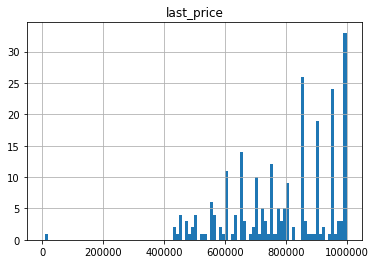

In [32]:
# Посмотрим как распределены данные по ценам
data.hist('last_price', bins=100, range=(0, 1000000))

# Цены начинаются от 400 тыс, то что меньше - явно нужно удалить

In [33]:
# Посмотрим в каких процентилях расположены данные
data['last_price'].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.99]).T

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
5%       1.864500e+06
10%      2.500000e+06
20%      3.190000e+06
30%      3.650000e+06
40%      4.100000e+06
50%      4.650000e+06
60%      5.290000e+06
70%      6.182687e+06
80%      7.580000e+06
90%      1.090000e+07
95%      1.530000e+07
97%      2.000000e+07
99%      3.600000e+07
max      7.630000e+08
Name: last_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4839535750>]],
      dtype=object)

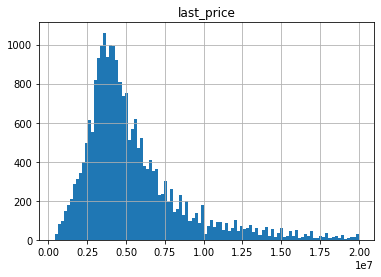

In [34]:
# Большинство данных расположены в цене 3 мнл, 97% данных до 20 млн.
# Остальные данные явно уникальные
data.hist('last_price', bins=100, range=(400000, 20000000))

In [35]:
# Посмотрим насколько сократятся наши данные при таких ограничениях
good_price = data.query('last_price.between(400000, 20000000, inclusive = True)')
print((len(data) - len(good_price))/len(data))
# Кол-во убранных позиций меньше 3%

0.02989429175475687


In [36]:
# Сделаем тоже самое для площади квартир
good_price['total_area'].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.99]).T

# Медиана 51 м.кв., есть 12 метровые и 460 метровые, посмотрим их распределение на диаграмме

count    22943.000000
mean        56.707870
std         24.792031
min         12.000000
5%          31.000000
10%         32.800000
20%         37.000000
30%         42.000000
40%         45.300000
50%         51.000000
60%         57.000000
70%         63.000000
80%         72.000000
90%         87.000000
95%        101.290000
97%        114.000000
99%        145.316000
max        460.800000
Name: total_area, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f483926e1d0>]],
      dtype=object)

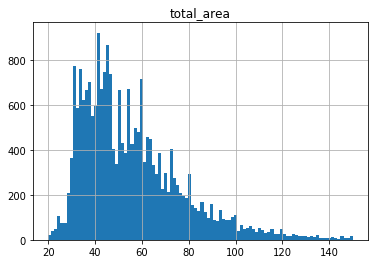

In [37]:
good_price.hist('total_area', bins=100, range=(20, 150))
# Нормальный диапазон от 20 до 150 м.кв

In [38]:
# Посмотрим насколько сократятся наши данные при таких ограничениях
good_data = good_price.copy(deep=True)
good_data = good_data.query('total_area.between(20, 150, inclusive = True)')
print((len(good_price) - len(good_data))/len(good_price))
# Кол-во убранных позиций меньше 1%, оставляем

0.009414636272501416


In [39]:
# Посмотрим что с потолками
good_data['ceiling_height'].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.99]).T

# Потолок 1 метр - неее, я там жить не хочу
# Сто метров, 35 этажей вы высоту, наверное для Кинг-Конга строили

count    13866.000000
mean         2.752488
std          1.283380
min          1.000000
5%           2.500000
10%          2.500000
20%          2.500000
30%          2.550000
40%          2.600000
50%          2.650000
60%          2.700000
70%          2.750000
80%          2.800000
90%          3.000000
95%          3.200000
97%          3.350000
99%          3.700000
max        100.000000
Name: ceiling_height, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4838aa0510>]],
      dtype=object)

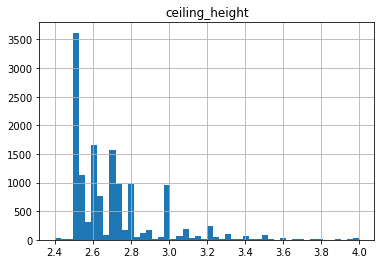

In [40]:
good_data.hist('ceiling_height', bins=50, range=(2.4, 4))
# Большинство потолков от 2,4 до 4 метров.
# Всё что не входит в этот диапазон явно не квартира
# Удалять не будем но при анализе высоты потолков информация явно пригодиться

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4838996790>]],
      dtype=object)

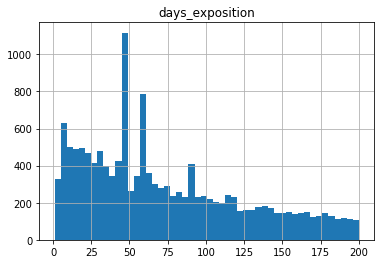

In [41]:
# Большинство объявлений с показателем Дней в экспозиции == 0 или Пусто, может быть только-что разместили объявление?!
# Построим диаграмму без этих значений
# Резко выделяется кол-во дней = 45, 60 и 90 возможно система автоматически закрывает объявления в этом промежутке
# Думаю при оценке результатов лучше будет избавиться от этих полей
good_data.hist('days_exposition', bins=50, range=(1, 200))

In [42]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22727 entries, 0 to 23698
Data columns (total 22 columns):
total_images            22727 non-null int64
last_price              22727 non-null float64
total_area              22727 non-null float64
first_day_exposition    22727 non-null datetime64[ns]
rooms                   22727 non-null int64
ceiling_height          13866 non-null float64
floors_total            22644 non-null Int64
living_area             22727 non-null float64
floor                   22727 non-null int64
is_apartment            22727 non-null bool
studio                  22727 non-null bool
open_plan               22727 non-null bool
kitchen_area            22727 non-null float64
balcony                 22727 non-null int64
locality_name           22727 non-null object
airports_nearest        17229 non-null Int64
cityCenters_nearest     17246 non-null Int64
parks_around3000        17247 non-null Int64
parks_nearest           7438 non-null Int64
ponds_around3000    

In [43]:
# Заполняем столбец 'floors_total'
good_data.query('floors_total != floors_total')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,NaN,NaN,30.800000,4,False,...,12.000000,0,Санкт-Петербург,39197,12373,1,123,0,NaN,49
237,4,2438033.0,28.1,2016-11-23,1,NaN,NaN,20.750000,1,False,...,6.923077,0,Санкт-Петербург,22041,17369,0,NaN,1,374,251
457,4,9788348.0,70.8,2015-08-01,2,NaN,NaN,38.400000,12,False,...,10.630000,0,Санкт-Петербург,37364,8322,2,309,2,706,727
671,4,6051191.0,93.6,2017-04-06,3,NaN,NaN,47.100000,8,False,...,16.800000,0,Санкт-Петербург,22041,17369,0,NaN,1,374,123
1757,5,3600000.0,39.0,2017-04-22,1,NaN,NaN,18.790036,9,False,...,9.608541,0,Санкт-Петербург,22735,11618,1,835,1,652,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21753,7,6800000.0,57.0,2017-05-01,2,NaN,NaN,32.801887,21,False,...,9.464151,0,Санкт-Петербург,17618,14600,2,104,0,NaN,36
22542,5,8500000.0,63.5,2017-05-24,2,2.8,NaN,36.542453,3,False,...,10.543396,0,Санкт-Петербург,51340,15363,0,NaN,1,853,512
22656,4,4574160.0,64.5,2017-04-02,2,NaN,NaN,31.700000,20,False,...,14.400000,0,Санкт-Петербург,22041,17369,0,NaN,1,374,127
22808,0,14569263.0,110.4,2016-11-20,3,NaN,NaN,45.380000,6,False,...,23.420000,0,Санкт-Петербург,19095,4529,0,NaN,0,NaN,260


In [44]:
good_data['floors_total'].isna().sum()

83

In [45]:
# Заполним поле 'floors_total', если поле пустое то добавляем к этажу +1
good_data['floors_total'] = good_data['floors_total'].fillna(good_data['floor']+1)

In [46]:
# Наиболее часто встречающаяся высота потолков 2.5м, заполню все пустые значение этим параметром
good_data['ceiling_height'].value_counts().sort_values(ascending=False).head(3)

2.5    3506
2.6    1640
2.7    1552
Name: ceiling_height, dtype: int64

In [47]:
good_data['ceiling_height'].isna().sum()

8861

In [48]:
# Заполняем пустые значение в высоте потолков наиболее частыми значениями 2.5 м
good_data['ceiling_height'] = good_data['ceiling_height'].fillna(2.5)

In [49]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22727 entries, 0 to 23698
Data columns (total 22 columns):
total_images            22727 non-null int64
last_price              22727 non-null float64
total_area              22727 non-null float64
first_day_exposition    22727 non-null datetime64[ns]
rooms                   22727 non-null int64
ceiling_height          22727 non-null float64
floors_total            22727 non-null Int64
living_area             22727 non-null float64
floor                   22727 non-null int64
is_apartment            22727 non-null bool
studio                  22727 non-null bool
open_plan               22727 non-null bool
kitchen_area            22727 non-null float64
balcony                 22727 non-null int64
locality_name           22727 non-null object
airports_nearest        17229 non-null Int64
cityCenters_nearest     17246 non-null Int64
parks_around3000        17247 non-null Int64
parks_nearest           7438 non-null Int64
ponds_around3000    

In [50]:
# Отобразим все данные по строке
pd.options.display.max_rows = 30
good_data.loc[186]

total_images                             12
last_price                        1.164e+07
total_area                             65.2
first_day_exposition    2018-10-02 00:00:00
rooms                                     2
ceiling_height                          2.5
floors_total                              5
living_area                            30.8
floor                                     4
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                             12
balcony                                   0
locality_name               Санкт-Петербург
airports_nearest                      39197
cityCenters_nearest                   12373
parks_around3000                          1
parks_nearest                           123
ponds_around3000                          0
ponds_nearest                           NaN
days_exposition                          49
Name: 186, dtype: object

- Лист самоконтроля
---
- [x]  <span style="color:green">***last_price*** - Поле заполненно полностью, странное минимальное значение = 12 190, квартир с такой ценой явно не бывает. Нужно почистить от Всплесков, экстримальные цены нам не к чему.
- [x]  <span style="color:green"> ***total_area*** - Среднее значение сильно отличается от Медианы. Нужно убирать Всплески - Квартиры по 900 м
- [x]  <span style="color:green"> ***first_day_exposition*** - Необходимо перевести в формат даты, пропусков в поле нет
- [x]  <span style="color:green"> ***ceiling_height*** - Есть 3 значения с высотой потолков менее 2х метров, поле заполнено не полностью, есть потолки сто метров. Посмотреть на данные
- [x]  <span style="color:green"> ***floors_total*** Перевести поле в int, есть пустые значения 
- [x]  <span style="color:green"> ***living_area*** - Есть пустые значения, заполнить по Коэффициенту и в зависимости от Общей площади
- [x]  <span style="color:green"> ***is_apartment*** - Заполнено не полностью, сделать допущение: Там где пусто проставить FALSE; Перевести поле в формат 'bool'
- [x]  <span style="color:green"> ***kitchen_area*** - Заполнено не везде, проставить по Коэффициенту по данным где есть кухни и общая площадь
- [x]  <span style="color:green"> ***balcony*** - Перевести в int; Проставить нули где значение опущено
- [x]  <span style="color:green"> ***locality_name*** - Тип населенного пункта убрать или заменить на ''; Пустые значения удалить - Кому нужна квартира где-то там?
- [x]  <span style="color:green"> ***airports_nearest*** - перевести в 'int'
- [x]  <span style="color:green"> ***cityCenters_nearest*** - перевести в 'int'
- [x]  <span style="color:green"> ***parks_around3000*** - перевести в 'int'; Поставлю Нули где пусто
- [x]  <span style="color:green"> ***parks_nearest*** - перевести в 'int'
- [x]  <span style="color:green"> ***ponds_around3000*** - перевести в 'int'; Поставлю Нули где пусто
- [x]  <span style="color:green"> ***ponds_nearest*** - перевести в 'int'
- [x]  <span style="color:green"> ***days_exposition*** - перевести в 'int'; Есть Пустые значения - Возможно передумали или купили в тот-же день - поставлю ноль; Есть значения более 4х лет - Про них явно забыли. Посмотреть визуально на это поле

### Шаг 3. Считаем и добавляем в таблицу

Добавляем поля в таблицу:
1. Цена (м2)
2. День Недели, Месяц, Год Публикации объявления
3. Этаж квартиры: 'Первый', 'Последний', 'Другой'
4. Соотношения Жилой и Общей площади, Площадь Кухни к общей площади

- Диаграмма scatter plot
- Сделать срезы данных


In [51]:
good_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [52]:
# 1. Добавляем цену за метр кв
good_data.loc[:, 'price_metr'] = round(good_data.loc[:, 'last_price'] / good_data.loc[:, 'total_area'])
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863,16028,1,482,2,755,0,120370.0
1,7,3350000.0,40.4,2018-12-04,1,2.50,11,18.6,1,False,...,2,Шушары,12817,18603,0,NaN,0,NaN,81,82921.0
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.3,4,False,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92786.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000.0
5,10,2890000.0,30.4,2018-09-10,1,2.50,12,14.4,5,False,...,0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95066.0


In [53]:
# 2. Добавляем День Недели, Месяц, Год Публикации объявления
good_data['weekday'] = good_data['first_day_exposition'].dt.weekday+1
good_data['month'] = good_data['first_day_exposition'].dt.month
good_data['year'] = good_data['first_day_exposition'].dt.year
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028,1,482,2,755,0,120370.0,4,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.50,11,18.6,1,False,...,18603,0,NaN,0,NaN,81,82921.0,2,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.3,4,False,...,13933,1,90,2,574,558,92786.0,4,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098,2,112,1,48,121,100000.0,2,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.50,12,14.4,5,False,...,NaN,NaN,NaN,NaN,NaN,55,95066.0,1,9,2018


In [54]:
#3. Этаж квартиры: 'Первый', 'Последний', 'Другой'
# Создаем функцию и тестируем ее
def flr(row):
    if row['floor'] == row['floors_total']:
        return 'Последний'
    elif row['floor'] == 1:
        return 'Первый'
    return 'Другой'

flr(good_data.loc[13])

'Последний'

In [55]:
good_data['floor_group'] = good_data.apply(flr, axis=1)
good_data.head(13)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year,floor_group
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,1,482,2,755,0,120370.0,4,3,2019,Другой
1,7,3350000.0,40.40,2018-12-04,1,2.50,11,18.600000,1,False,...,0,NaN,0,NaN,81,82921.0,2,12,2018,Первый
2,10,5196000.0,56.00,2015-08-20,2,2.50,5,34.300000,4,False,...,1,90,2,574,558,92786.0,4,8,2015,Другой
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,2,112,1,48,121,100000.0,2,6,2018,Другой
5,10,2890000.0,30.40,2018-09-10,1,2.50,12,14.400000,5,False,...,NaN,NaN,NaN,NaN,55,95066.0,1,9,2018,Другой
6,6,3700000.0,37.30,2017-11-02,1,2.50,26,10.600000,6,False,...,0,NaN,0,NaN,155,99196.0,4,11,2017,Другой
7,5,7915000.0,71.60,2019-04-18,2,2.50,24,41.203774,22,False,...,0,NaN,0,NaN,0,110545.0,4,4,2019,Другой
8,20,2900000.0,33.16,2018-05-23,1,2.50,27,15.430000,26,False,...,NaN,NaN,NaN,NaN,189,87455.0,3,5,2018,Другой
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,0,NaN,0,NaN,289,88525.0,7,2,2017,Другой
10,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,1,310,2,553,137,127525.0,4,11,2017,Другой


In [56]:
# 4. Соотношения Жилой и Общей площади, Площадь Кухни к общей площади
good_data['part_living'] = good_data['living_area'] / good_data['total_area']
good_data['part_kitchen'] = good_data['kitchen_area'] / good_data['total_area']

good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year,floor_group,part_living,part_kitchen
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755,0,120370.0,4,3,2019,Другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.50,11,18.6,1,False,...,0,NaN,81,82921.0,2,12,2018,Первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.3,4,False,...,2,574,558,92786.0,4,8,2015,Другой,0.612500,0.148214
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48,121,100000.0,2,6,2018,Другой,0.320000,0.410000
5,10,2890000.0,30.4,2018-09-10,1,2.50,12,14.4,5,False,...,NaN,NaN,55,95066.0,1,9,2018,Другой,0.473684,0.299342


[Text(0, 0.5, 'cityCenters_nearest'), (0, 300000), Text(0.5, 0, 'price_metr')]

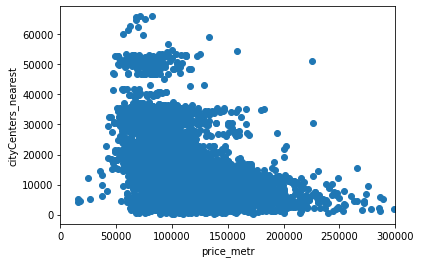

In [57]:
# 5. Диаграмма scatter plot
plt.scatter(good_data.price_metr, good_data.cityCenters_nearest)
plt.gca().set(xlim=(0, 300000), xlabel='price_metr', ylabel='cityCenters_nearest')
# На графике очень хорошо прослеживается динамика при приближении к центру города, цена за кв. метр возрастает
# Но есть и странные значения где всё наоборот. С этими значениями нужно явно поработать

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48387d42d0>],
      dtype=object)

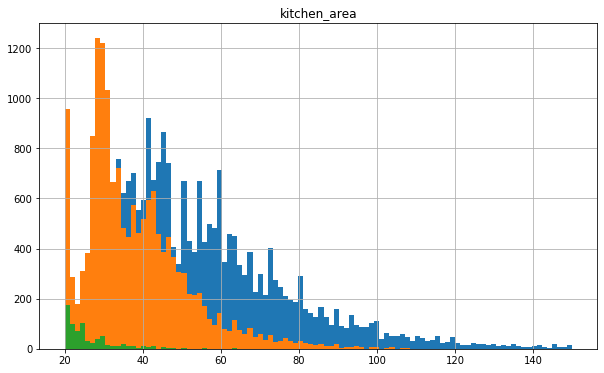

In [58]:
# Совместим данные по Площади: Общая, Жилая и Кухня
ax = good_data.hist('total_area', bins=100, range=(20, 150), figsize=(10, 6))
good_data.hist('living_area', bins=100, range=(20, 150), ax=ax)
good_data.hist('kitchen_area', bins=100, range=(20, 150), ax=ax)
# Очень странно. Похоже на то что местами жилая зона больше общей, это надо исправлять.
# Вариантов тут несколько: Расширять общую площать, сокращать жилую или кухонную. Т.к. быстро это не понять
# а на результат задания это сильно не влияет, пока просто обращу на это внимание.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4838569b90>]],
      dtype=object)

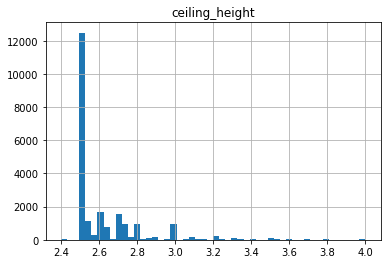

In [59]:
good_data.hist('ceiling_height', bins=50, range=(2.4, 4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48384b9790>]],
      dtype=object)

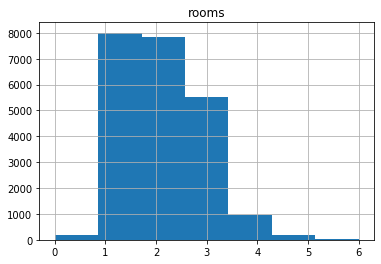

In [60]:
good_data.hist('rooms', bins=7, range=(0, 6))

In [61]:
pvt = good_data.pivot_table(index='rooms', aggfunc='count', values='last_price')
pvt.columns = ['count_rooms']
pvt

,count_rooms
rooms,
0,188
1,8005
2,7846
3,5534
4,951
5,174
6,23
7,5
8,1


Данные по цене, площади и высоте потолков уже скорректированы и просмотрены ранее.
Выводы по ним следующие:
 - **Цены**: Адекватные цены от 400 тыс до 20 млн.;
 - **Площадь**: Нормальный диапазон от 20 до 150 м.кв, медиана по площади 51 м.кв;
 - **Высота потолков**: Большинство квартир имеет высоту потолков = 2,5 м. Нормальный диапазон от 2,4 м до 4 м. 
     Всё что не входит в этот диапазон является выбросом;
 - **Кол-во комнат**: Большинство квартир это 1 и 2 комнатные, меньше 3х комнатных, всё остальное существенно меньше

## Время продажи квартиры
Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f483836e950>]],
      dtype=object)

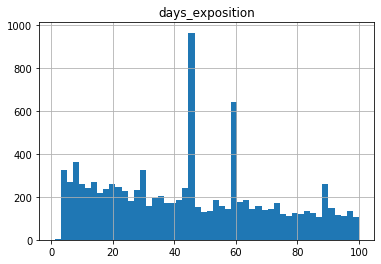

In [62]:
# Резко выделяется кол-во дней = 45, 60 и 90 возможно система автоматически закрывает объявления в этом промежутке
# Думаю при оценке результатов лучше будет избавиться от этих полей
good_data.hist('days_exposition', bins=50, range=(1, 100))

In [63]:
good_data['days_exposition'].value_counts().head(3)

0     2940
45     875
60     538
Name: days_exposition, dtype: int64

In [64]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22727 entries, 0 to 23698
Data columns (total 29 columns):
total_images            22727 non-null int64
last_price              22727 non-null float64
total_area              22727 non-null float64
first_day_exposition    22727 non-null datetime64[ns]
rooms                   22727 non-null int64
ceiling_height          22727 non-null float64
floors_total            22727 non-null Int64
living_area             22727 non-null float64
floor                   22727 non-null int64
is_apartment            22727 non-null bool
studio                  22727 non-null bool
open_plan               22727 non-null bool
kitchen_area            22727 non-null float64
balcony                 22727 non-null int64
locality_name           22727 non-null object
airports_nearest        17229 non-null Int64
cityCenters_nearest     17246 non-null Int64
parks_around3000        17247 non-null Int64
parks_nearest           7438 non-null Int64
ponds_around3000    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48381754d0>]],
      dtype=object)

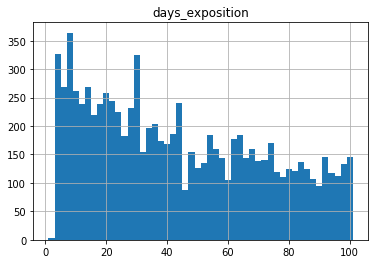

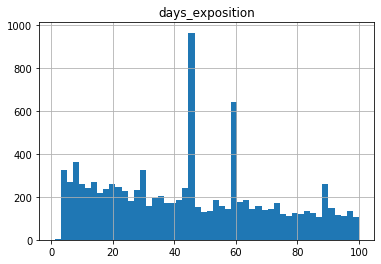

In [65]:
# Построим диаграмму без автоматического закрытия в периоды 45, 60 и 90 дней
our_list = [45, 60, 90]
good_data.query('days_exposition not in @our_list').hist('days_exposition', bins=50, range=(1, 101))

good_data.hist('days_exposition', bins=50, range=(1, 100))

In [66]:
good_data.query('days_exposition not in @our_list').describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.99])

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year,part_living,part_kitchen
count,21148.000000,2.114800e+04,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,...,7017.000000,16205.000000,7919.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000,21148.000000
mean,9.910677,5.377611e+06,55.830319,1.991630,2.659103,10.751513,31.988854,5.896350,9.886574,0.599253,...,493.342312,0.736748,525.264048,161.620390,95353.749338,3.556696,6.409590,2017.366985,0.563881,0.187020
std,5.598253,3.091218e+06,21.883402,0.945168,1.045638,6.602987,15.007167,4.887396,4.538293,0.958067,...,338.766636,0.915491,277.223317,215.916243,32539.949200,1.782799,3.474462,1.047797,0.102055,0.072552
min,0.000000,4.300000e+05,20.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,13.000000,0.000000,7963.000000,1.000000,1.000000,2014.000000,0.038462,0.000000
5%,1.000000,1.900000e+06,31.000000,1.000000,2.500000,4.000000,15.100000,1.000000,5.400000,0.000000,...,97.000000,0.000000,96.000000,0.000000,41550.250000,1.000000,1.000000,2015.000000,0.395349,0.099762
10%,2.000000,2.500000e+06,32.800000,1.000000,2.500000,5.000000,16.300000,1.000000,6.000000,0.000000,...,162.000000,0.000000,151.000000,0.000000,55894.200000,1.000000,2.000000,2016.000000,0.430108,0.110687
20%,5.000000,3.150000e+06,37.000000,1.000000,2.500000,5.000000,18.000000,2.000000,6.600000,0.000000,...,250.000000,0.000000,256.000000,11.000000,71126.200000,2.000000,3.000000,2017.000000,0.480000,0.127660
30%,7.000000,3.620000e+06,42.000000,1.000000,2.500000,5.000000,20.000000,3.000000,7.500000,0.000000,...,329.800000,0.000000,351.400000,29.000000,80696.000000,2.000000,4.000000,2017.000000,0.511509,0.141330
40%,8.000000,4.100000e+06,45.200000,2.000000,2.500000,8.000000,27.000000,4.000000,8.300000,0.000000,...,395.000000,0.000000,433.000000,53.000000,88000.000000,3.000000,5.000000,2017.000000,0.543264,0.157025
50%,10.000000,4.577500e+06,51.000000,2.000000,2.500000,9.000000,30.000000,4.000000,9.000000,0.000000,...,458.000000,0.000000,511.000000,82.000000,94444.000000,4.000000,6.000000,2017.000000,0.570033,0.171875


Итого - большинство квартир закрываются с 3х дневного срока и дальше по убыванию

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4838086550>]],
      dtype=object)

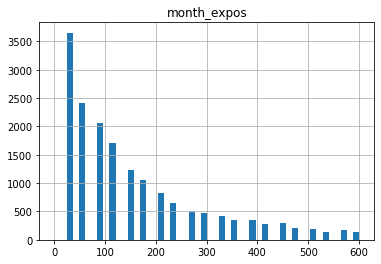

In [67]:
# Добавим группировку по 30 дням
good_data['month_expos'] = ((good_data['days_exposition']+29)// 30)*30
good_data.query('days_exposition not in @our_list').hist('month_expos', bins=50, range=(1, 600))

# Около 50% квартир продается в диапазоне 3 х месяцев
# После 600 дней вероятность продать квартиру = почти ноль

## Факторы влияющие на продажу квартиры

#### Зависимость Цены и кол-ва Комнат

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48388a0150>]],
      dtype=object)

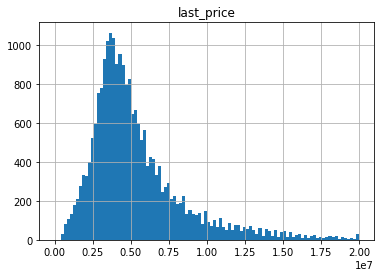

In [68]:
good_data.hist('last_price', bins=100, range=(0, 20000000)) 

0.47701669747615033

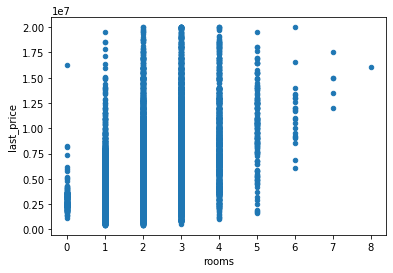

In [69]:
good_data.plot(x='rooms', y='last_price', kind='scatter')
good_data['last_price'].corr(good_data['rooms'])

#### Зависимость Цены и кол-ва комнат положительная и составляет 48%, оно и понятно, т.к. в основном при увеличении количества комнат кол-во метров жилой площади так же растет

## Корреляция - цена за кв. м. и кол-во комнат

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4833bfb850>]],
      dtype=object)

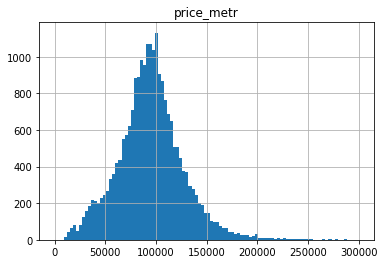

In [70]:
# Поработаем с кол-ом комнат и ценой
# Цена за метр начинается с 10 000 до 200 000
good_data.hist('price_metr', bins=100, range=(0, 300000))

0.7616278897629677

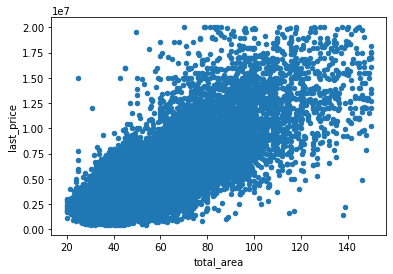

In [93]:
# Цена очень сильно зависит от кол-ва квадратных метров, корреляция высокая = 0,76
good_data.plot(x='total_area', y='last_price', kind='scatter')
good_data['total_area'].corr(good_data['last_price'])

-0.12793593365891326

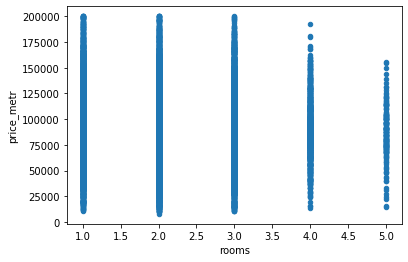

In [72]:
# Слабая зависимость сохранилась, т.е. при увеличении кол-ва комнат цена за квадратный метр 
# немного снижается
room_list = [1, 2, 3, 4, 5]
good_room = good_data.query('rooms in @room_list and price_metr <= 200000')
good_room.plot(x='rooms', y='price_metr', kind='scatter')
good_room['price_metr'].corr(good_room['rooms'])

### Зависимость Этаж-Цена кв. Метр

In [73]:
good_data.pivot_table(index='floor_group', values='price_metr', aggfunc='mean').sort_values('price_metr')


,price_metr
floor_group,
Первый,80245.133192
Последний,86313.691260
Другой,99002.193121


-0.12602305663764302

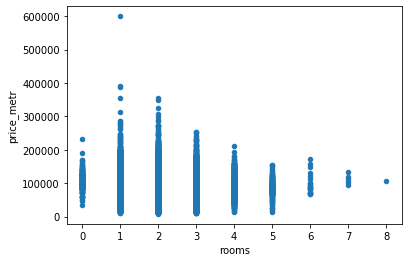

In [74]:
good_data.plot(x='rooms', y='price_metr', kind='scatter')
good_data['price_metr'].corr(good_data['rooms'])

#### Зависимость цены и этажности явно есть

Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'. "

In [75]:
good_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_metr', 'weekday', 'month',
       'year', 'floor_group', 'part_living', 'part_kitchen', 'month_expos'],
      dtype='object')

In [116]:
columns_stat = good_data.filter(items = ['price_metr','ceiling_height', 'living_area', 'days_exposition'
                                        , 'rooms', 'total_area'
                                        , 'airports_nearest', 'cityCenters_nearest'
                                        ,'parks_nearest', 'ponds_nearest', 'days_exposition'
                                        ])

In [123]:
columns_stat.corr()['price_metr']
# В принципе цена за квадратный метр больше всего зависит от Близости к центру, немного влияет Высота потолка, кол-во комнат

price_metr             1.000000
ceiling_height         0.112897
living_area           -0.016747
days_exposition       -0.008679
rooms                 -0.126023
total_area             0.078217
airports_nearest      -0.040180
cityCenters_nearest   -0.395175
parks_nearest          0.089692
ponds_nearest         -0.075224
days_exposition       -0.008679
Name: price_metr, dtype: float64

In [124]:
# Отберем 10 населенных пунктов с наибольшим числом объявлений и закинем этот список в переменную: 'top_cities'
top_cities = good_data['locality_name'].value_counts().head(10)
top_cities

Санкт-Петербург    14847
Мурино               590
Кудрово              472
Шушары               439
Всеволожск           396
Пушкин               355
Колпино              337
Парголово            326
Гатчина              307
Выборг               235
Name: locality_name, dtype: int64

In [125]:
good_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_metr', 'weekday', 'month',
       'year', 'floor_group', 'part_living', 'part_kitchen', 'month_expos'],
      dtype='object')

In [126]:
# Создаем столбец с расстоянием до центра в км
good_data['cityCenter_km'] = good_data['cityCenters_nearest'] // 1000

In [127]:
# Посчитаем среднюю цену за квадратный метр в топ 10 городов
(good_data
 .query('locality_name in @top_cities.index')
 .pivot_table(index='locality_name', values=['price_metr', 'cityCenter_km', 'rooms', 'total_area'], 
              aggfunc='median', fill_value=0)
 .sort_values(by='price_metr', ascending=False)
)

,cityCenter_km,price_metr,rooms,total_area
locality_name,,,,
Санкт-Петербург,12,103670.0,2,53.000
Пушкин,27,99650.0,2,53.000
Кудрово,0,95675.5,1,40.000
Парголово,19,91780.5,1,42.950
Мурино,21,86175.5,1,37.465
Шушары,24,76829.0,2,50.200
Колпино,32,74722.0,2,50.000
Гатчина,0,67797.0,2,45.000
Всеволожск,0,65789.0,2,53.550


В целом удаленность от СПб влияет на стоимость м.кв.
Например Выборг расположен на расстоянии до СПб в 120 км, Гатчина в 42 км и стоимость жилья там дешевле.
Но вот в Пушкино стоимость жилья почти равна СПб, хотя расстояние до центра там 27 км - видимо сам район и инфроструктура тоже влияют на стоимость.

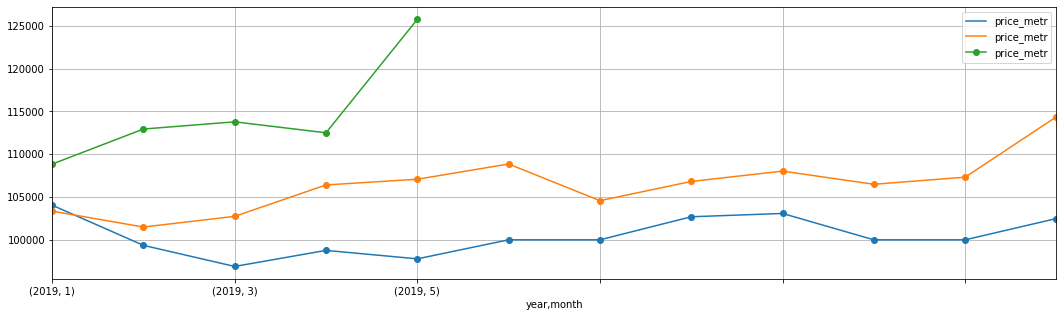

In [128]:
# Посмотрим стоимость кв.м. на предмет сезонности, влияет ли стоимость по годам и месяцам, на примере СПб
ax = (good_data[good_data['locality_name'] == 'Санкт-Петербург']
 .query('year==2017')
 .pivot_table(index=['year', 'month'], values='price_metr', aggfunc='median')
 .plot(grid=True, style='o-', figsize=(18, 5))
)

(good_data[good_data['locality_name'] == 'Санкт-Петербург']
 .query('year==2018')
 .pivot_table(index=['year', 'month'], values='price_metr', aggfunc='median')
 .plot(grid=True, style='o-', ax=ax, figsize=(18, 5))
)

(good_data[good_data['locality_name'] == 'Санкт-Петербург']
 .query('year==2019')
 .pivot_table(index=['year', 'month'], values='price_metr', aggfunc='median')
 .plot(grid=True, style='o-', ax=ax, figsize=(18, 5))
)


In [129]:
(good_data[good_data['locality_name'] == 'Санкт-Петербург']
 .pivot_table(index='year', columns='month', values='price_metr', aggfunc='median')
)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122263.5,116162.0
2015,100000.0,98682.5,95161.0,109551.0,103053.0,101610.0,102532.0,103380.5,111905.0,97433.0,95743.5,94280.0
2016,100000.0,101351.0,99211.0,100324.5,100847.0,100000.0,95702.0,95013.5,100484.0,103030.0,96991.5,97698.5
2017,104048.0,99355.0,96890.0,98765.0,97778.0,100000.0,100000.0,102693.0,103078.5,100000.0,100000.0,102487.0
2018,103352.0,101493.0,102740.0,106410.0,107075.0,108856.0,104572.5,106816.0,108025.0,106487.0,107317.0,114375.0
2019,108840.5,112939.0,113780.0,112500.0,125749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подписи получились так себе, но в целом понятно что по годам цена за кв. метр растет и лучше всего в декабре, в феврале затихание, май 2019 - очень высокие цены.
До 2017 года данные сильно валатильные и скорее всего опираться на них в расчетах не стоит.

## Удаленность от центра города в СПб

In [130]:
# Выбираем только СПб, без пустых значений в поле Растояние до центра
# pd.options.display.max_columns = 30
spb_data = good_data.copy(deep=True)
spb_data = spb_data[(spb_data['locality_name'] == 'Санкт-Петербург')&(spb_data['cityCenters_nearest'] == spb_data['cityCenters_nearest'])]

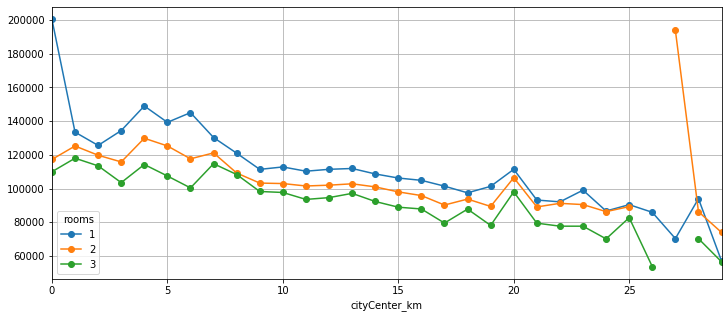

In [131]:
# Возьмем только квартиры от 1-3 комнат в СПБ и посмотрим как меняется цена в зависимости от приближения к центру,
# в разрезе комнат
(spb_data.query('rooms in (1, 2, 3)')
        .pivot_table(index='cityCenter_km',columns='rooms', values='price_metr', aggfunc='median')
        .plot(grid=True, style='o-', figsize=(12, 5))
       )

Центр города лежит в диапазоне 8 км, именно с этого расстояния цены начинают резко расти вверх.
Плюс есть какие-то 2е неадекватные по цене квартиры. Одна двухкомнатная 27 км от центра города, с золотыми люстрами а другая однокомнатная в центре - личная квартира Президента с выходом в Кремль.

## Сегмент квартир в центре

In [132]:
# Добавляем столбец с разделением квартир на Центр и Перефирию

def filter_centr(row):
    """
    Если больше 8 км растояние от цента то это Переферия, если меньше то это центр
    """
    if row['cityCenter_km'] > 8:
        return 'переферия'
    elif row['cityCenter_km'] <= 8:
        return 'центр'
    return 'не определено'

spb_data['centr_or_not'] = spb_data.apply(filter_centr, axis=1)
spb_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_metr,weekday,month,year,floor_group,part_living,part_kitchen,month_expos,cityCenter_km,centr_or_not
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,120370.0,4,3,2019,Другой,0.472222,0.231481,0,16,переферия
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.300000,4,False,...,92786.0,4,8,2015,Другой,0.612500,0.148214,570,13,переферия
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,100000.0,2,6,2018,Другой,0.320000,0.410000,150,8,центр
7,5,7915000.0,71.6,2019-04-18,2,2.50,24,41.203774,22,False,...,110545.0,4,4,2019,Другой,0.575472,0.263966,0,11,переферия
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.600000,7,False,...,88525.0,7,2,2017,Другой,0.714754,0.106557,300,15,переферия


## Определим различие по этажам

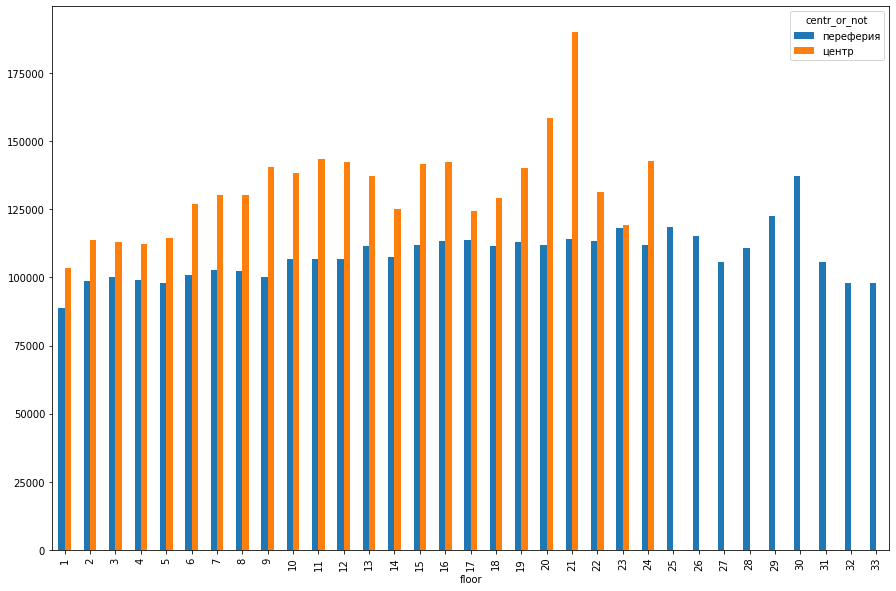

In [133]:
# Различие в цене за м.кв по этажам в СПб в разбивке по Центру и Переферии
(spb_data.pivot_table(index = ['floor'], 
                 columns = 'centr_or_not', 
                 values = 'price_metr', 
                 aggfunc = 'median')
        .plot(kind = 'bar', figsize = (15,10)))

- В целом в Центре цена за метр выше на любом этаже.
- Начиная с 6 этажа отличие за метр начинает сильно увеличиваться. 
- Скорее всего это новые дома которые больше 5го этажа. 
- Моя любовь живет на 21 этаже почти где луна и там дороже всего в центре но мне все равно :)

## Определим различие по Группе этажа

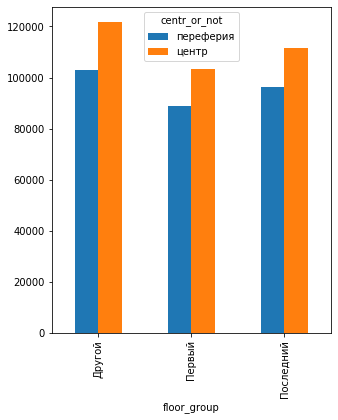

In [134]:
# Различие в цене за м.кв по группам этажей (Первый, не Первый - Последний)
(spb_data.pivot_table(index = ['floor_group'], 
                 columns = 'centr_or_not', 
                 values = 'price_metr', 
                 aggfunc = 'median')
        .plot(kind = 'bar', figsize = (5,6)))

Ну вот, на первом этаже как никто не хотел жить так и не хочет, в центре или на переферии не важно.
Зато можно продать свой первый этаж в центре и переехать на переферию в любой другой этаж без доплаты.
Последний этаж не так плох как первый.

## Определим различие по потолкам

In [135]:
# Различие в цене за м.кв по потолкам 
# Добавим для начала потолочную градацию от 2.5, от 2.7, от 3 и от 4м 

def ceil(row):
    if row['ceiling_height'] < 2.5:
        return 'до 2.5'
    if row['ceiling_height'] < 2.7:
        return 'от 2.5'
    if row['ceiling_height'] < 3:
        return 'от 2.7'
    if row['ceiling_height'] >= 4:
        return 'от 3'
    if row['ceiling_height'] >= 8:
        return 'от 4'
    if row['ceiling_height'] != row['ceiling_height']:
        return 'не определено'
spb_data['ceiling_group'] = spb_data.apply(ceil, axis=1)

spb_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,weekday,month,year,floor_group,part_living,part_kitchen,month_expos,cityCenter_km,centr_or_not,ceiling_group
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,4,3,2019,Другой,0.472222,0.231481,0,16,переферия,от 2.7
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.300000,4,False,...,4,8,2015,Другой,0.612500,0.148214,570,13,переферия,от 2.5
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,2,6,2018,Другой,0.320000,0.410000,150,8,центр,None
7,5,7915000.0,71.6,2019-04-18,2,2.50,24,41.203774,22,False,...,4,4,2019,Другой,0.575472,0.263966,0,11,переферия,от 2.5
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.600000,7,False,...,7,2,2017,Другой,0.714754,0.106557,300,15,переферия,от 2.5


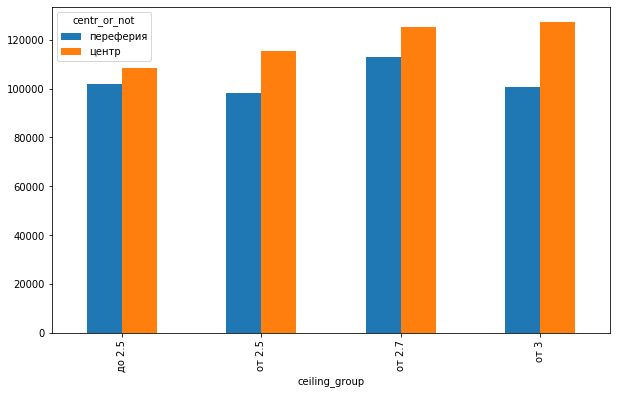

In [136]:
(spb_data.pivot_table(index = ['ceiling_group'], 
                 columns = 'centr_or_not', 
                 values = 'price_metr', 
                 aggfunc = 'median')
        .plot(kind = 'bar', figsize = (10,6)))

Наиболее дорогой вариант квартир с потолками от 2.7 м, а вот от 3 метров в Переферии не пользуется популярностью

## To be Аппартаменты or not to be

In [137]:
spb_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_metr', 'weekday', 'month',
       'year', 'floor_group', 'part_living', 'part_kitchen', 'month_expos',
       'cityCenter_km', 'centr_or_not', 'ceiling_group'],
      dtype='object')

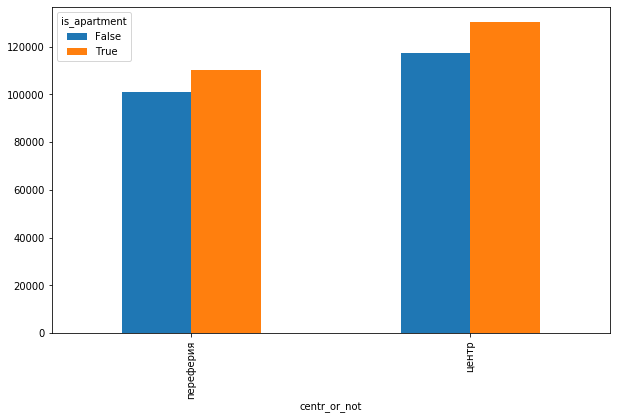

In [138]:
(spb_data.pivot_table(index = ['centr_or_not'], 
                 columns = 'is_apartment', 
                 values = 'price_metr', 
                 aggfunc = 'median')
        .plot(kind = 'bar', figsize = (10,6)))

In [139]:
svd_appart = spb_data.pivot_table(columns = ['is_apartment'], 
                 values = 'price_metr', 
                 aggfunc = 'median')
svd_appart

is_apartment,False,True
price_metr,103575.5,112093.5


In [140]:
(svd_appart.values[:,1] / svd_appart.values[:,0] -1) *100

array([8.22395258])

Цены на аппартаменты в среднем выше на 8% чем на обычные квартиры

In [152]:
spb_filt_centr = spb_data[spb_data['centr_or_not'] == 'центр'].filter(items = ['price_metr', 'total_area', 'rooms'
                                                                              ,'ceiling_height'])
spb_filt_peref = spb_data[spb_data['centr_or_not'] == 'переферия'].filter(items = ['price_metr', 'total_area', 'rooms'
                                                                              ,'ceiling_height'])
All_dt = good_data.filter(items = ['price_metr', 'total_area', 'rooms','ceiling_height'])

print(spb_filt_centr.corr()['price_metr'])
print()
print(spb_filt_peref.corr()['price_metr'])
print()
print(All_dt.corr()['price_metr'])

price_metr        1.000000
total_area       -0.193643
rooms            -0.326482
ceiling_height    0.193571
Name: price_metr, dtype: float64

price_metr        1.000000
total_area       -0.028553
rooms            -0.286829
ceiling_height    0.044811
Name: price_metr, dtype: float64

price_metr        1.000000
total_area        0.078217
rooms            -0.126023
ceiling_height    0.112897
Name: price_metr, dtype: float64


### Общий итог по Корреляции: Чем ближе к центру, тем больше каждый фактор начинает коррелировать с ценой

### Шаг 5. Общий вывод

1. Большинство квартир представленных на рынке имеют кол-во комнат от одной до 3х, доля таких квартир составляет 92%:
    - 1 комн = 34%;
    - 2 комн = 33,5%
    - 3 комн = 24,5%
---
2. Центр города в Санкт-Петербурге начинаяется с растояния **8 км до центра**, цены на жилье здесь стартуют с цены **110 тыс** за 1 кв. метр
---
3. В целом удаленность от СПб влияет на стоимость м.кв.
Например Выборг расположен на расстоянии до СПб в 120 км, Гатчина в 42 км и стоимость жилья там дешевле.
Но вот в Пушкино стоимость жилья почти равна СПб, хотя расстояние до центра там 27 км - видимо сам район и инфроструктура тоже влияют на стоимость
---
4. Цены в центре СПб по всем параметрам выше, этаж это или потолок не важно.
    - Более высокие цены на жилье в квартирах этажностью от 6го этажа, видимо в новых домах в центре
---
5. На первом этаже жить никто не хочет, вот и цены там обычно ниже, не важно центр это или переферия.
    - Но зато можно найти квартиру не на первом и не на последнем этаже продав квартиру в центре на первом
---
6. Наиболее дорогие квартиры с потолками от 2,7 метра, они даже более дорогие чем квартиры на переферии от 3х метров
---
7. Цены на аппартаменты на 8% дороже чем в обычных квартирах